In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.interpolate as interp
from scipy.optimize import curve_fit

# 15 Feb 2019 - Crafting a solar max spectrum

In [4]:
!awk -F "\"*,\"*" '{ print $2 FS $3 }' chaffincode-working/sorce_solarmax_2003_0-2400.csv > chaffincode-working/solarmax_sorce.dat
!awk -F "\"*,\"*" '{ print $2 FS $3 }' chaffincode-working/timedsee_solarmax_2003_0-190.csv > chaffincode-working/solarmax_timedsee.dat

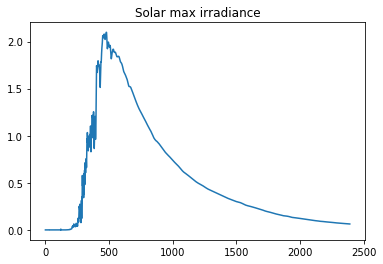

In [3]:
# load in the data, which is a composite I stitched together by hand from SORCE Solar Spectral irradiance and TIMED/SEE Solar spectral irradiance.
# SORCE lacked data for 40.5-114.5 nm, so for that range I used TIMED/SEE.
solarmax = np.loadtxt("chaffincode-working/Solar data/solarmax_composite.dat", skiprows=1)

# Plot solar max
plt.plot(solarmax[:, 0], solarmax[:, 1])
plt.title("Solar max irradiance")
# plt.xlim(0,500)
plt.show()

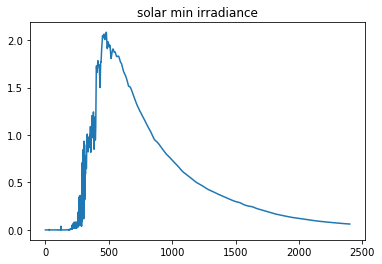

In [4]:
# Plot solar min
solarmin = np.loadtxt("chaffincode-working/Solar data/ref_solar_irradiance_whi-2008_ver2.dat", skiprows=142)
plt.plot(solarmin[:,0], solarmin[:,1])
plt.title("solar min irradiance")
# plt.xlim(0,500)
plt.show()

Note: It doesn't look like there is much difference but that's because most of the action happens in the UV, so if you look at between 0 to 500 nm (zoom in) you see more difference.

Now, how to convert IRRADIANCE (W/m^2/nm) to PHOTONS at mars?

What we have is W/(m^2 nm), which is J/(s m^2 nm). We can just divide by the wavelength-dependent energy of the photon (hc/λ) to get photons on top. Then the bottom is s m^2 nm, which is what Mike has in his older file. Cool. 

To scale the flux to Mars, we note that these measurements we have are from satellites in orbit around earth, so they are at 1 AU. So just multiply the measurement by the surface area of the orbital sphere of Earth (4π(1AU)^2) and then divide by the orbital sphere at Mars' surface area, 4π(1.63 AU)^2, where the value there comes from Stellarium pulled for the date of the observations I'm using, 2003-11-01.

The last step is to divide the whole thing by 10000 because 10000cm^2 = 1m^2 and Mike had his in per cm^2.

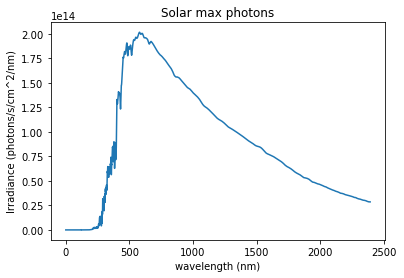

In [11]:
solardata = pd.DataFrame(solarmax, columns=["λ", "irradiance"])
h = 6.626e-34
c = 3e8
sphereratio = 1/(1.63**2) # this is the ratio of the orbital sphere surface areas at Earth (top) and Mars. 

photflux = solardata["irradiance"] * ((solardata["λ"]* 10**(-9))/(h*c)) * sphereratio * (1/10000)


solardata["γ/s/cm^2/nm"] = pd.Series(photflux, index=solardata.index)
plt.plot(solardata["λ"], solardata["γ/s/cm^2/nm"])
plt.title("Solar max photons")
plt.ylabel("Irradiance (photons/s/cm^2/nm)")
plt.xlabel("wavelength (nm)")
plt.show()

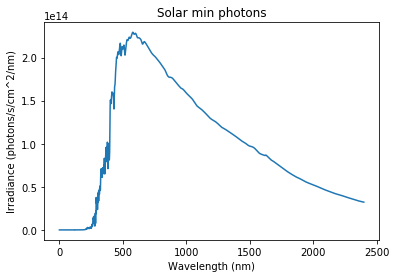

In [9]:
solarminphot = np.loadtxt("chaffincode-working/marssolarphotonflux_solarmin.dat")
plt.plot(solarminphot[:,0], solarminphot[:,1])
plt.title("Solar min photons")
plt.ylabel("Irradiance (photons/s/cm^2/nm)")
plt.xlabel("Wavelength (nm)")
plt.show()

Nice, it looks like I've successfully gotten the photon flux for solar max. I'll save it to a file and stop for now.

In [8]:
solardata[0:4]

,λ,irradiance,γ/s/cm^2/nm
0,0.5,0.000024,2.307973e+06
1,1.5,0.000332,9.423355e+07
2,2.5,0.000095,4.481802e+07
3,3.5,0.000054,3.593721e+07


In [18]:
#solardata.to_csv("chaffincode-working/marssolarphotonflux_solarmax.dat", sep='\t', columns=["λ", "γ/s/cm^2/nm"], index=False)

# 22 November 2019 - Solar Mean

So even though the irradiance in the UV doesn't change much between solar min and solar max, and it doesn't much matter for the chemistry, I still think it would be best to use a solar mean spectrum for the paper so people are less likely to harass me. Creating that spectrum will be the focus of this section.

According to Ed Thiemann and Momo, the best way to get a sense of where we are in the solar cycle is to use the Ly α emission. This information is available in the <a href="http://lasp.colorado.edu/lisird/data/sorce_solstice_ssi_high_res/">SORCE Solstice High Res data</a>. 

According to this, solar mean occurred in:
- Mid 2005
- Mid 2011
- Mid 2016

May 15 looks to be a good date for each year. I'll grab spectra for May 15 from each of those dates from the <a href="http://lasp.colorado.edu/lisird/data/sorce_ssi_l3/">normal res SORCE solstice data</a>, which covers the relevant wavelength range, convert to photon flux as before, then mean them together.

In [4]:
!awk '{ print $2 FS $3 }' chaffincode-working/sorce_solarmean_20050615_0-2400.txt > chaffincode-working/sorce_solarmean_20050615.dat
!awk '{ print $2 FS $3 }' chaffincode-working/sorce_solarmean_20110621_0-2400.txt > chaffincode-working/sorce_solarmean_20110621.dat
!awk '{ print $2 FS $3 }' chaffincode-working/sorce_solarmean_20160615_0-2400.txt > chaffincode-working/sorce_solarmean_20160615.dat

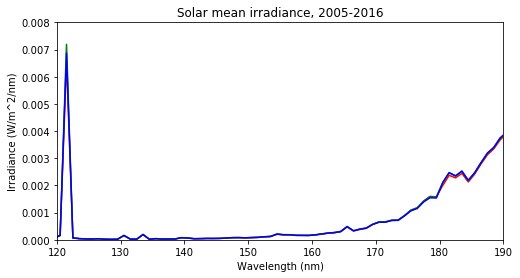

In [21]:
# load in the solar mean data, which is a composite I stitched together by hand from SORCE Solar Spectral irradiance and TIMED/SEE Solar spectral irradiance.
# SORCE lacked data for 40.5-114.5 nm, so for that range I used TIMED/SEE.
solarmean1 = np.loadtxt("chaffincode-working/Solar data/sorce_solarmean_20050615.dat", skiprows=3)
solarmean2 = np.loadtxt("chaffincode-working/Solar data/sorce_solarmean_20110621.dat", skiprows=3)
solarmean3 = np.loadtxt("chaffincode-working/Solar data/sorce_solarmean_20160615.dat", skiprows=3)

# Plot solar max
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(solarmean1[:, 0], solarmean1[:, 1], color="red")
ax.plot(solarmean2[:, 0], solarmean2[:, 1], color="green")
ax.plot(solarmean3[:, 0], solarmean3[:, 1], color="blue")
# ax.set_yscale("log")
plt.title("Solar mean irradiance, 2005-2016")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Irradiance (W/m^2/nm)")
plt.xlim(120,190)
plt.ylim(0,0.008)
plt.show()

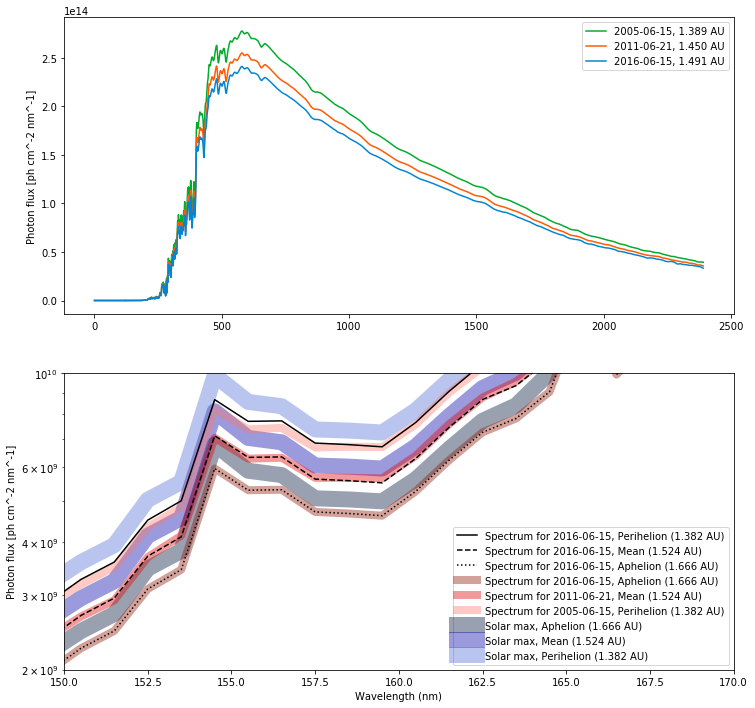

In [17]:
# Convert to Photon flux at Mars orbit

# Mars orbital radii by date (from Stellarium):

# 2005-06-15: 1.389 AU
# 2011-06-21: 1.450 AU
# 2016-06-15: 1.491 AU

s1 = pd.DataFrame(solarmean1, columns=["λ", "irradiance"])
s2 = pd.DataFrame(solarmean2, columns=["λ", "irradiance"])
s3 = pd.DataFrame(solarmean3, columns=["λ", "irradiance"])

h = 6.626e-34
c = 3e8
sphereratio = [1/(1.389**2), 1/(1.450**2), 1/(1.491**2)] # this is the ratio of the orbital sphere surface areas at Earth (top) and Mars. 

fig, ax = plt.subplots(2, 1, sharex=False, figsize=(12,12))
# Specific 2005, 2011, 2016 observations
photflux1 = s1["irradiance"] * ((s1["λ"]* 10**(-9))/(h*c)) * sphereratio[0] * (1/10000)
photflux2 = s2["irradiance"] * ((s2["λ"]* 10**(-9))/(h*c)) * sphereratio[1] * (1/10000)
photflux3 = s3["irradiance"] * ((s3["λ"]* 10**(-9))/(h*c)) * sphereratio[2] * (1/10000)
s1["γ/s/cm^2/nm"] = pd.Series(photflux1, index=s1.index)
s2["γ/s/cm^2/nm"] = pd.Series(photflux2, index=s2.index)
s3["γ/s/cm^2/nm"] = pd.Series(photflux3, index=s3.index)
ax[0].plot(s1["λ"], s1["γ/s/cm^2/nm"], color="xkcd:kelly green", label="2005-06-15, 1.389 AU")
ax[0].plot(s2["λ"], s2["γ/s/cm^2/nm"], color="xkcd:bright orange", label="2011-06-21, 1.450 AU")
ax[0].plot(s3["λ"], s3["γ/s/cm^2/nm"], color="xkcd:cerulean", label="2016-06-15, 1.491 AU")
ax[0].legend()

# Using the same irradiance (irradiance when Mars was at 1.491 AU in 2016) for perihelion, mean, and aphelion orbital radius
photflux4 = s3["irradiance"] * ((s3["λ"]* 10**(-9))/(h*c)) * 1/(1.666**2) * (1/10000)
photflux5 = s3["irradiance"] * ((s3["λ"]* 10**(-9))/(h*c)) * 1/(1.524**2) * (1/10000)
photflux6 = s3["irradiance"] * ((s3["λ"]* 10**(-9))/(h*c)) * 1/(1.382**2) * (1/10000)
s3["γ/s/cm^2/nm_ap"] = pd.Series(photflux4, index=s3.index)
s3["γ/s/cm^2/nm_mean"] = pd.Series(photflux5, index=s3.index)
s3["γ/s/cm^2/nm_peri"] = pd.Series(photflux6, index=s3.index)
ax[1].plot(s3["λ"], s3["γ/s/cm^2/nm_peri"], color="xkcd:black", linestyle="-", label="Spectrum for 2016-06-15, Perihelion (1.382 AU)")
ax[1].plot(s3["λ"], s3["γ/s/cm^2/nm_mean"], color="xkcd:black", linestyle="--", label="Spectrum for 2016-06-15, Mean (1.524 AU)")
ax[1].plot(s3["λ"], s3["γ/s/cm^2/nm_ap"], color="xkcd:black", linestyle=":", label="Spectrum for 2016-06-15, Aphelion (1.666 AU)")

# different observations for different orbital radii
photflux7 = s3["irradiance"] * ((s3["λ"]* 10**(-9))/(h*c)) * 1/(1.666**2) * (1/10000)
photflux8 = s2["irradiance"] * ((s2["λ"]* 10**(-9))/(h*c)) * 1/(1.524**2) * (1/10000)
photflux9 = s1["irradiance"] * ((s1["λ"]* 10**(-9))/(h*c)) * 1/(1.382**2) * (1/10000)
s3["γ/s/cm^2/nm_ap_2"] = pd.Series(photflux7, index=s3.index)
s2["γ/s/cm^2/nm_mean_2"] = pd.Series(photflux8, index=s2.index)
s1["γ/s/cm^2/nm_peri_2"] = pd.Series(photflux9, index=s1.index)
ax[1].plot(s3["λ"], s3["γ/s/cm^2/nm_ap_2"], color="xkcd:brick red", linewidth=8, alpha=0.4, zorder=-1, label="Spectrum for 2016-06-15, Aphelion (1.666 AU)")
ax[1].plot(s2["λ"], s2["γ/s/cm^2/nm_mean_2"], color="xkcd:red", linewidth=8, alpha=0.4, zorder=-1, label="Spectrum for 2011-06-21, Mean (1.524 AU)")
ax[1].plot(s1["λ"], s1["γ/s/cm^2/nm_peri_2"], color="xkcd:salmon", linewidth=8, alpha=0.4, zorder=-1, label="Spectrum for 2005-06-15, Perihelion (1.382 AU)")



# try it with solar max and varying orbital radius
photflux_max_ap = solardata["irradiance"] * ((solardata["λ"]* 10**(-9))/(h*c)) * 1/(1.666**2) * (1/10000)
photflux_max_mean = solardata["irradiance"] * ((solardata["λ"]* 10**(-9))/(h*c)) * 1/(1.524**2) * (1/10000)
photflux_max_peri = solardata["irradiance"] * ((solardata["λ"]* 10**(-9))/(h*c)) * 1/(1.382**2) * (1/10000)
solardata["γ/s/cm^2/nm_ap"] = pd.Series(photflux_max_ap, index=solardata.index)
solardata["γ/s/cm^2/nm_mean"] = pd.Series(photflux_max_mean, index=solardata.index)
solardata["γ/s/cm^2/nm_peri"] = pd.Series(photflux_max_peri, index=solardata.index)
ax[1].plot(solardata["λ"], solardata["γ/s/cm^2/nm_ap"], color="xkcd:navy", linewidth=16, alpha=0.4, zorder=-2, label="Solar max, Aphelion (1.666 AU)")
ax[1].plot(solardata["λ"], solardata["γ/s/cm^2/nm_mean"], color="xkcd:royal blue", linewidth=16, alpha=0.4, zorder=-2, label="Solar max, Mean (1.524 AU)")
ax[1].plot(solardata["λ"], solardata["γ/s/cm^2/nm_peri"], color="xkcd:cornflower blue", linewidth=16, alpha=0.4, zorder=-2, label="Solar max, Perihelion (1.382 AU)")
ax[1].set_xlim(150, 170)
ax[1].set_ylim(2*10**9, 10**10)
ax[1].set_yscale("log")

ax[1].legend()

ax[1].set_xlabel("Wavelength (nm)")
ax[0].set_ylabel("Photon flux [ph cm^-2 nm^-1]")
ax[1].set_ylabel("Photon flux [ph cm^-2 nm^-1]")

plt.show()

## Takeaways of looking at different solar spectra and orbital radius combinations

### Panel 1 - specific observations

- when Mars orbits at a larger radius, there are fewer photons incident per unit area. Obvious.



### Panel 2 

1. (Black lines) Use same irradiance spectrum, test effect of orbital radius -- as before, more incoming photons per unit area during perihelion/smaller orbital radii.
1. (Red lines) Use a different spectrum for aphelion, mean, and perihelion orbital radii. The spectra are for an orbital radius that is "kind of close" to the radii of perihelion, aphelion, and mean. "Kinda close" means it's the ones I found in the SORCE and TIMED data, so they're not perfect. As expected, fewer photons per unit area during aphelion.
1. (Blue lines) Using the same solar MAX irradiance spectrum for aphelion, mean, and perihelion. The effect of using the spectrum for solar max is that you see a few more photons than you would expect if you were using the solar mean spectrum. The increase is < 25% though.



### Takeaways

1. For the solar mean spectrum, it's fine to average the 3 different observation campaigns into a "mean solar mean" spectrum.
1. The "mean solar mean" spectrum can be used for aphelion, mean orbit, and perihelion, and it won't make a difference in the incoming photons.
1. Go ahead and use the mean Mars orbital radius and the mean solar mean spectrum and we should be good.

## Interpolate each solar mean spectrum to have evenly spaced wavelengths

In [12]:
# Interpolate the irradiance and photons in the solar data dataframe I made earlier

def interpolate_solar_spectrum(spec, AU, show_plots=True):
    """
    Input: 
        spec: a Pandas dataframe of SOLAR MEAN spectrum data from 0.1-2390 nm or so, with bins centered
              on every half nm wavelength until 310 nm, and arbitrarily binned thereafter.
              Columns:
                  λ: wavelength in nm
                  irradiance: irradiance in W/m^2/nm
    Output:
        A Pandas dataframe whole_spectrum from 0.5-2399.5 nm, properly binned every half nm.
        
    Since the input spectrum must be for SOLAR MEAN, the photon flux is calculated for the mean
    Mars orbital radius of 1.524 AU.
    """
    
    # for converting to photons
    h = 6.626e-34
    c = 3e8

    col = [spec.columns[0], spec.columns[1]]

    
    f_irr = interp.interp1d(spec[col[0]], spec[col[1]])

    newx = np.arange(309.5, 2390.5, 1)
    new_irr = f_irr(newx)

    # check to make sure it looks right
    if show_plots:
        plt.figure(figsize=(10,5))
        plt.title("Check that spectrum looks okay after interpolation")
        plt.plot(spec[col[0]], spec[col[1]], color="blue", linewidth=5, label="data", alpha=0.5)
        plt.plot(newx, new_phot, color="black", label="interpolated")
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Irradiance (W m^-2 nm^-1)")
        plt.legend()
        plt.show()

    # make a new dataframe containing the interpolated data
    interp_data = pd.DataFrame(np.column_stack((newx, new_irr)), columns=[col[0], col[1]])

    # put the interpolated data together with the data that started out fine for one new data frame 
    newsolardata = pd.concat([spec[:310], interp_data[1:]], ignore_index="true")
    
    # This data is still missing 10 or so datapoints near the end (Mike's solar photon flux goes out to 2399.5).
    # fit the end so we can get it out to the same wavelength
    def func(x, a, b, c):
        return a * np.exp(b * x) + c

    # do the same fit for irradiance for completeness, even though I don't really need the irradiance data
    datatofit = newsolardata[1000:]
    popt, pcov = curve_fit(func, datatofit[col[0]], datatofit[col[1]], p0=(1.5, -0.0001, 1))
    if show_plots:
        plt.figure(figsize=(10,5))
        plt.title("Fitting the long irradiance tail")
        plt.plot(newsolardata[col[0]], newsolardata[col[1]], label="data + interpolated values")
        plt.plot(datatofit[col[0]], func(datatofit[col[0]], popt[0], popt[1], popt[2]), color="purple", label="fit to irradiance")
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Irradiance (W m^-2 nm^-1)")
        plt.legend()
        plt.show()
    
    # make a dataframe containing extrapolated data
    extrap_wavelengths = np.arange(2390.5, 2400.5, 1)
    extrap_irradiance = func(extrap_wavelengths, popt[0], popt[1], popt[2])
    tail = pd.DataFrame(np.column_stack((extrap_wavelengths, extrap_irradiance)), columns=[col[0], col[1]])
    if show_plots:
        plt.figure(figsize=(10,5))
        plt.title("Shows final extrapolated tail")
        plt.plot(newsolardata[col[0]], newsolardata[col[1]], color="green", label="data + interpolated values")
        plt.plot(tail[col[0]], tail[col[1]], color="purple", label="extrapolated tail")
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Irradiance (W m^-2 nm^-1)")
        plt.legend()
        plt.show()
    
    #make the FINAL dataframe with ALL data for solar max
    whole_spectrum = newsolardata.append(tail, ignore_index=True)
    whole_spectrum["photon flux (γ/s/cm^2/nm)"] = whole_spectrum[col[1]] * ((whole_spectrum[col[0]] * 10**(-9))/(h*c)) * 1/(AU**2) * (1/10000)
    
    if show_plots:
        plt.figure(figsize=(10,5))
        plt.title("Finalized spectrum, in photon flux, with interpolation and extrapolation")
        plt.plot(whole_spectrum[col[0]], whole_spectrum["photon flux (γ/s/cm^2/nm)"])
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Photons (ph cm^-2 s^-1)")
        plt.show()
        print()
    
    return whole_spectrum


In [13]:
sm2005 = pd.DataFrame(solarmean1, columns=["λ (nm)", "irradiance (W/m^2/nm)"])
sm2011 = pd.DataFrame(solarmean2, columns=["λ (nm)", "irradiance (W/m^2/nm)"])
sm2016 = pd.DataFrame(solarmean3, columns=["λ (nm)", "irradiance (W/m^2/nm)"])

finalized_spectrum_2005 = interpolate_solar_spectrum(sm2005, 1.389, False)
finalized_spectrum_2011 = interpolate_solar_spectrum(sm2011, 1.450, False)
finalized_spectrum_2016 = interpolate_solar_spectrum(sm2016, 1.491, False)

print(finalized_spectrum_2005[0:1])
print(finalized_spectrum_2011[0:1])
print(finalized_spectrum_2016[0:1])

   λ (nm)  irradiance (W/m^2/nm)  photon flux (γ/s/cm^2/nm)
0     0.5               0.000005              591866.130974
   λ (nm)  irradiance (W/m^2/nm)  photon flux (γ/s/cm^2/nm)
0     0.5               0.000006              681041.750622
   λ (nm)  irradiance (W/m^2/nm)  photon flux (γ/s/cm^2/nm)
0     0.5               0.000004              465835.714012


In [14]:
dfs = [finalized_spectrum_2005, finalized_spectrum_2011, finalized_spectrum_2016]
mean_solar_mean = pd.concat(dfs).mean(level=0)
mean_solar_mean[0:4]

,λ (nm),irradiance (W/m^2/nm),photon flux (γ/s/cm^2/nm)
0,0.5,0.000005,5.795812e+05
1,1.5,0.000077,2.799588e+07
2,2.5,0.000033,1.982858e+07
3,3.5,0.000020,1.695254e+07


In [15]:
mean_solar_mean.to_csv("chaffincode-working/marssolarphotonflux_solarmean.dat", sep='\t', columns=["λ (nm)", "photon flux (γ/s/cm^2/nm)"], index=False)